In [1]:
import pandas as pd
import numpy as np
import dataset
import statsmodels as sts
import matplotlib.pyplot as plt
import seaborn as sns
import communities
import plots
import json

In [2]:
augmented_cmu = dataset.get_augmented_cmu()
imdb_df = dataset.get_imdb_dataset()
boxofficemojo = dataset.get_boxofficemojo_dataset()
rottentomatoes = dataset.get_rottentomatoes_dataset()
awards_df = dataset.load_dataset('Output/awards.csv')

/Users/daniillikhobaba/EPFL/ADA/ada-2023-project-biasbusters/dataset.py:27: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_basics = pd.read_csv('Data/imdb/title.basics.tsv', sep='\t')


In [3]:
imdb_df = imdb_df.drop(columns=['title_type', 'genres', 'runtime_minutes', 'movie_name', 'release_year'])

We need to use re-labeled llm features (fixed couple of issues). The code for datasets loading is too complex to change it, so let's just merge it with re-labeled llm features.

In [4]:
plot_features = pd.read_csv('plot_features.csv')
llm_columns = ['topic', 'mood', 'target_audience', 'temporal_setting', 'location_setting']

augmented_cmu = pd.merge(
    augmented_cmu.drop(columns=llm_columns), 
    plot_features[['movie_wikipedia_id'] + llm_columns],
    on='movie_wikipedia_id'
)

In [5]:
augmented_cmu[['languages', 'countries', 'genres', 'topic', 'mood', 'target_audience',
       'temporal_setting', 'location_setting']] = augmented_cmu[
            ['languages', 'countries', 'genres', 'topic', 'mood', 'target_audience',
       'temporal_setting', 'location_setting']
    ].map(json.loads, na_action='ignore')

In [6]:
augmented_cmu[['languages', 'countries', 'genres']] = \
    augmented_cmu[['languages', 'countries', 'genres']].map(
        lambda x: [y.lower() for y in x.values()], na_action='ignore')

In [7]:
set(y for x in augmented_cmu['topic'].dropna() for y in x) - \
    set(y for x in augmented_cmu['genres'].dropna() for y in x)

{'conflict', 'historical', 'romance'}

Topics are just genres. Let's merge them into genres

In [8]:
augmented_cmu['genres'] = (augmented_cmu['genres'] + augmented_cmu['topic'])\
    .map(lambda x: list(set(x)), na_action='ignore')
augmented_cmu = augmented_cmu.drop(columns='topic')

In [9]:
augmented_cmu['language'].unique()

array(['en'], dtype=object)

In [10]:
augmented_cmu = augmented_cmu.drop(columns='language')

In [11]:
augmented_cmu = augmented_cmu[
    ~augmented_cmu[['genres', 'mood', 'target_audience', 'temporal_setting', 'location_setting']]\
    .isna().any(axis=1)]

In [12]:
plot_analysis = pd.merge(
    left=augmented_cmu,
    right=imdb_df,
    how='inner', on='imdb_id')
awards_aggregated = awards_df.groupby('imdb_id').agg({'award': list,'category': list,'win': list}).reset_index()

plot_analysis = pd.merge(left=plot_analysis, right=awards_aggregated, how='left', on='imdb_id')
plot_analysis = pd.merge(left=plot_analysis, right=boxofficemojo, how='left', on='imdb_id')

In [13]:
plot_analysis.to_csv('plot_analysis.csv', index=None)

In [14]:
plot_analysis.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'imdb_id',
       'imdb_name', 'imdb_year', 'mood', 'target_audience', 'temporal_setting',
       'location_setting', 'is_adult', 'avg_rating', 'num_votes', 'award',
       'category', 'win', 'domestic_distributor', 'domestic_opening', 'budget',
       'releases', 'performance_domestic', 'performance_international',
       'performance_worldwide', 'metric_roi', 'percentage_domestic',
       'percentage_international'],
      dtype='object')

In [15]:
augmented_cmu.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'imdb_id',
       'imdb_name', 'imdb_year', 'mood', 'target_audience', 'temporal_setting',
       'location_setting'],
      dtype='object')

In [16]:
plot_analysis['performance_worldwide'].notna().sum()

6442

# Regression analysis framework

In [17]:
plot_analysis['avg_rating'].notna().mean()

1.0

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

In [19]:
def one_hot_encode_multilabel(df, column_name):
    """
    Applies one-hot encoding to a column with multilabel classes in a DataFrame.

    :param df: pandas DataFrame containing the column to encode.
    :param column_name: string name of the column that contains multilabel classes.
    :return: DataFrame with original column replaced by one-hot encoded columns.
    """
    df = df.reset_index(drop=True)
    mlb = MultiLabelBinarizer()
    
    encoded_data = mlb.fit_transform(df[column_name])
    encoded_df = pd.DataFrame(encoded_data, columns=[f'{column_name}_{class_}' for class_ in mlb.classes_])
    
    df = df.drop(column_name, axis=1).join(encoded_df)
    
    return df

In [20]:
plot_analysis[['release_year', 'runtime', 'countries', 'genres']]

,release_year,runtime,countries,genres
0,2001,98.0,[united states of america],"[horror, thriller, action, science fiction, su..."
1,1987,110.0,[united kingdom],"[thriller, erotic thriller, psychological thri..."
2,1983,106.0,[germany],[drama]
3,2002,86.0,[south africa],"[world cinema, fantasy, adventure, family film]"
4,1997,93.0,[united states of america],"[drama, romantic comedy, comedy, romance film,..."
...,...,...,...,...
18208,2000,106.0,"[france, united states of america]","[comedy, drama, parody, americana]"
18209,1993,107.0,[united states of america],"[thriller, erotic thriller, psychological thri..."
18210,1994,NaN,[india],"[drama, comedy, action, crime]"
18211,2011,120.0,[united states of america],"[drama, mystery, science fiction]"


In [21]:
plot_analysis.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'imdb_id',
       'imdb_name', 'imdb_year', 'mood', 'target_audience', 'temporal_setting',
       'location_setting', 'is_adult', 'avg_rating', 'num_votes', 'award',
       'category', 'win', 'domestic_distributor', 'domestic_opening', 'budget',
       'releases', 'performance_domestic', 'performance_international',
       'performance_worldwide', 'metric_roi', 'percentage_domestic',
       'percentage_international'],
      dtype='object')

In [22]:
one_hotted = one_hot_encode_multilabel(plot_analysis, 'mood')

In [23]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

In [24]:
one_hotted.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'imdb_id',
       'imdb_name', 'imdb_year', 'target_audience', 'temporal_setting',
       'location_setting', 'is_adult', 'avg_rating', 'num_votes', 'award',
       'category', 'win', 'domestic_distributor', 'domestic_opening', 'budget',
       'releases', 'performance_domestic', 'performance_international',
       'performance_worldwide', 'metric_roi', 'percentage_domestic',
       'percentage_international', 'mood_dark', 'mood_dramatic',
       'mood_exciting', 'mood_fantastical', 'mood_inspirational',
       'mood_lighthearted', 'mood_romantic'],
      dtype='object')

In [27]:
def fit_regression_model(df, feature_columns, target_feature):
    """
    Fits a regression model using one-hot encoding for categorical features with multilabel classes
    and standardizes numerical features.
    
    :param df: pandas DataFrame containing the data.
    :param feature_columns: list of feature column names to include in the model.
    :param target_feature: the name of the target feature for regression.
    """
    # Create a copy of the DataFrame to avoid modifying the original one
    df_copy = df.copy()
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Process each feature column
    formula_parts = []
    for column in feature_columns:
        # Check if the column is categorical
        if df_copy[column].dtype == 'O' or df_copy[column].dtype.name == 'category':
            # Apply one-hot encoding to the column
            df_copy = one_hot_encode_multilabel(df_copy, column)
            encoded_columns = [col for col in df_copy.columns if col.startswith(f'{column}_')]
            formula_parts.extend([f'C({col})' for col in encoded_columns])
        else:
            # For numerical columns, apply standardization
            df_copy[column] = scaler.fit_transform(df_copy[[column]])
            formula_parts.append(column)
    
    formula = f'{target_feature} ~ ' + ' + '.join(formula_parts)
    
    mod = smf.ols(formula=formula, data=df_copy)
    res = mod.fit()
    
    # Extract model parameters for plotting
    variables = res.params.index
    coefficients = res.params.values
    p_values = res.pvalues
    standard_errors = res.bse.values
    
    # Sort them all by the absolute value of coefficients for plotting
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    
    plt.figure(figsize=(12, 2 + int(len(l1)/4)))
    plt.errorbar(l1, np.array(range(len(l1))), xerr=2*np.array(l3), linewidth=1,
                 linestyle='none', marker='o', markersize=3,
                 markerfacecolor='black', markeredgecolor='black', capsize=5)
    
    plt.vlines(0, 0, len(l1), linestyle='--')
    plt.title(f'Coefficients of regression model for target "{target_feature}" with ±2se intervals; p-values less than 0.05 are printed')
    plt.xlabel('Coefficient value in the model')
    
    for i, (coef, p) in enumerate(zip(l1, l4)):
        if p < 0.05:  # Only annotate significant p-values
            plt.text(coef, i, f'p={p:.2e}', fontsize=8, verticalalignment='bottom')
    
    plt.yticks(range(len(l2)), l2)
    plt.show()
    
    print(res.summary())

# Regression analysis for reviews

In [28]:
plot_analysis.columns

Index(['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'release_year',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'plot_summary', 'word_count', 'char_count', 'avg_word_length',
       'sentence_count', 'lexical_diversity', 'sentiment_polarity', 'imdb_id',
       'imdb_name', 'imdb_year', 'mood', 'target_audience', 'temporal_setting',
       'location_setting', 'is_adult', 'avg_rating', 'num_votes', 'award',
       'category', 'win', 'domestic_distributor', 'domestic_opening', 'budget',
       'releases', 'performance_domestic', 'performance_international',
       'performance_worldwide', 'metric_roi', 'percentage_domestic',
       'percentage_international'],
      dtype='object')

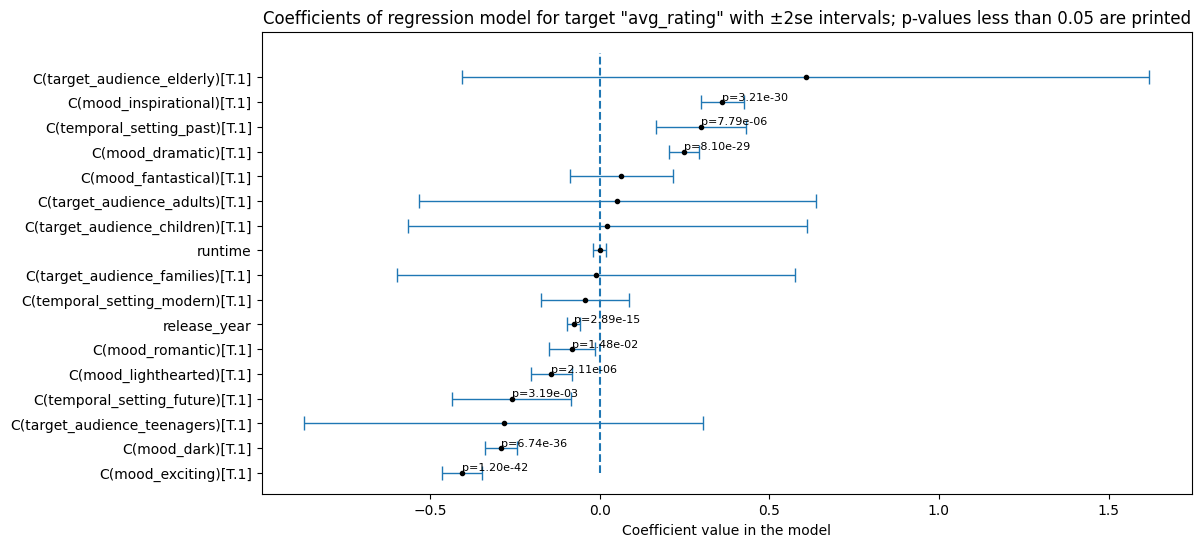

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     97.91
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:12:33   Log-Likelihood:                -25455.
No. Observations:               16179   AIC:                         5.095e+04
Df Residuals:                   16161   BIC:                         5.108e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [29]:
fit_regression_model(plot_analysis, ['runtime', 'mood', 'target_audience', 'temporal_setting'], 'avg_rating')